In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage import data,io, filters
from scipy import ndimage as ndi

In [2]:
from skimage.color import label2rgb


# Function taken from skimage tutorials, could probably be improved to better suit our data
def segmentator(image, lower, upper, save=None):
    elevation_map = filters.sobel(image)
    markers = np.zeros_like(image)
    markers[image < lower] = 1
    markers[image > upper] = 2

    segments = watershed(elevation_map, markers)

    segments = ndi.binary_fill_holes(segments - 1)
    labeled, _ = ndi.label(segments)
    image_label_overlay = label2rgb(labeled, image=image, bg_label=0)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    axes[0].imshow(image, cmap=plt.cm.gray)
    axes[0].contour(segments, [0.5], linewidths=1.2, colors='y')
    axes[1].imshow(image_label_overlay)
   
    for a in axes:
        a.axis('off')

    plt.tight_layout()

    plt.show()
    if save != None:
        fig.savefig(save, format="svg", dpi=1200)

    return labeled

#### Place Image Location and name below

In [5]:
img_dir = "./images/220922"
img_name = "image2_PRO.tif"

In [6]:
# Load our image
img_path = img_dir + "/" + img_name
img = io.imread(img_path)
img.shape

(7795, 3267, 3)

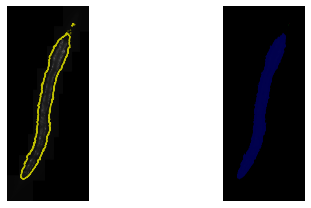

In [9]:

# These Values need to be adjusted depending on the number of channels present. For our 3 channel images 
# [mcherry, DAPI, POL], these settings should work. We generate our mask based on the DAPI channel and then 
# apply it to our other channels. Depending on how images are projected, the channels value may be at a different position.
# Use img.shape to check the dimensions of the array containing the image data. Default projected outputs from frankenstein
# appear to always have the channels parameter as the final element of the array. 
ref = img[:,:,2]
mapping = img[:,:,1]

# These determine the threshold for our watershed, they will often need to be adjusted based on the image.
upper = np.quantile(mapping, 0.90)
lower = np.quantile(mapping, 0.75)

data = segmentator(mapping, lower, upper)

# Because our watershed isn't ideal for this data, we take all segments detected and convert
# them into a mask
data[data != 0] = 1


# Apply masks to different channels
masked = mapping * data
masked_red = img[:,:,0] * data
masked_ref = ref * data



# Inefficient code to remove all extra space on the periphery of the image. Could definitely be
# improved, slow af.
to_delete_x = []

for i in range(len(masked)):
    if np.all(masked[i] == 0):
        to_delete_x.append(i)

masked = np.delete(masked, to_delete_x, 0)
masked_red = np.delete(masked_red, to_delete_x, 0)
masked_ref = np.delete(masked_ref, to_delete_x, 0)

masked = masked.T
masked_red = masked_red.T
masked_ref = masked_ref.T

to_delete_y = []

for i in range(len(masked)):
    if np.all(masked[i] == 0):
        to_delete_y.append(i)

masked = np.delete(masked, to_delete_y, 0)
masked_red = np.delete(masked_red, to_delete_y, 0)
masked_ref = np.delete(masked_ref, to_delete_y, 0)

if(masked.shape[0] > masked.shape[1]):
    masked_ref = masked_ref.T
    masked_red = masked_red.T
    masked = masked.T


cut = [masked_red, masked, masked_ref]

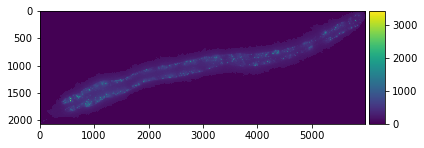

In [11]:
masked.shape
io.imshow(masked)

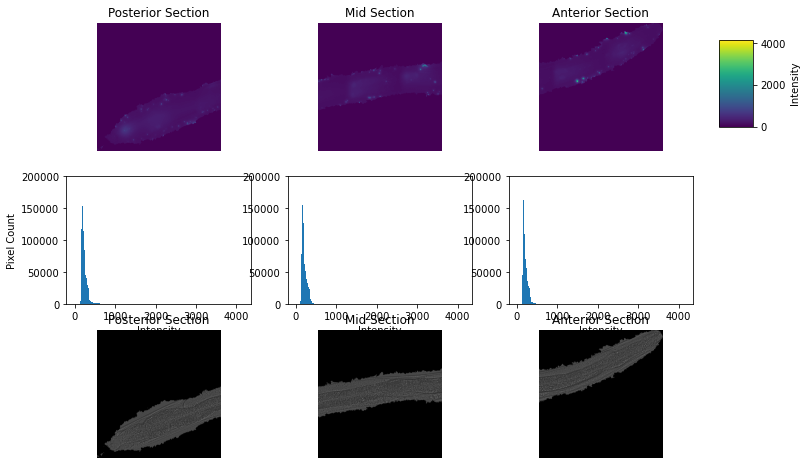

In [12]:
# This block attempts to create a sample figure from the data in the image. It is all dependant on the input
# but will attempt to divide the worm into three sections(Only works for straight worms, which is fairly achievable)
# with sodium azide. 

img_data = cut[0] 
ref_img = cut[2]

ref_max_intensity = np.max(ref_img) + 50
max_intensity = np.max(img_data) + 50

width = img_data.shape[1]
third = width // 3

img_left = img_data[:, :third]
img_mid = img_data[:, third:(2 * third)]
img_right = img_data[:, (2 * third):]

ref_left = ref_img[:, :third]
ref_mid = ref_img[:, third:(2 * third)]
ref_right = ref_img[:, (2 * third):]


fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=False, sharey = False)

im1 = axes[0][0].imshow(img_left, vmin = 0, vmax = max_intensity)
im2 = axes[0][1].imshow(img_mid, vmin = 0, vmax = max_intensity)
im3 = axes[0][2].imshow(img_right, vmin = 0, vmax = max_intensity)

rm1 = axes[2][0].imshow(ref_left, vmin = 0, vmax = ref_max_intensity, cmap="gray")
rm2 = axes[2][1].imshow(ref_mid, vmin = 0, vmax = ref_max_intensity, cmap="gray")
rm3 = axes[2][2].imshow(ref_right, vmin = 0, vmax = ref_max_intensity, cmap="gray")

hist1 = axes[1][0].hist(img_left[img_left != 0], bins = 256, range = (0,max_intensity))
hist2 = axes[1][1].hist(img_mid[img_mid != 0], bins = 256, range = (0,max_intensity))
hist3 = axes[1][2].hist(img_right[img_right != 0], bins = 256, range = (0,max_intensity))

for i in axes[1]:
    i.set_xlabel("Intensity")

pixel_counts = hist1[0] + hist2[0] + hist3[0]

for i in axes[1]:
    i.set_ybound(upper=np.max(hist1[0]))

for i in axes[1]:
    i.set_yticks(i.get_yticks()[::1])

# for i in axes[1]:



axes[1][0].set_ylabel("Pixel Count")

for i in axes[0]:
    i.axis('off')

for i in axes[2]:
    i.axis('off')

axes[0][0].set_title("Posterior Section")
axes[0][1].set_title("Mid Section")
axes[0][2].set_title("Anterior Section")

axes[2][0].set_title("Posterior Section")
axes[2][1].set_title("Mid Section")
axes[2][2].set_title("Anterior Section")


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.7, 0.04, 0.15])
fig.colorbar(im1, cax=cbar_ax, label = "Intensity")

plt.show()
